In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim

In [3]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
class Puasson1DPINN(nn.Module):
    def __init__(self, layers):
        super(Puasson1DPINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(layers)):
            self.hidden_layers.append(nn.Linear(layers[i-1], layers[i]))

    def forward(self, x_t):
        for layer in self.hidden_layers[:-1]:
            x_t = torch.tanh(layer(x_t))
        x_t = self.hidden_layers[-1](x_t)
        return x_t
    
    def compute_gradients(self, x_t):
        x_t.requires_grad = True

        u = self.forward(x_t)

        u_x = torch.autograd.grad(outputs=u, inputs=x_t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0][:, 0]
        u_xx = torch.autograd.grad(outputs=u_x, inputs=x_t, grad_outputs=torch.ones_like(u_x), create_graph=True, allow_unused=True)[0][:, 0]
        u_t = torch.autograd.grad(outputs=u, inputs=x_t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0][:, 1]
        return u, u_x, u_xx, u_t

    def dirichlet_conditions(self, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D):
        u, _, _, _ = self.compute_gradients(x_t_bc_top_bottom_1D)
        return torch.mean((u - u_bc_top_bottom_1D) ** 2)

    def neuman_conditions(self, x_t_bc_left_1D, x_t_bc_right_1D):
        alpha = 1
        u_left, u_x_left, _, _ = self.compute_gradients(x_t_bc_left_1D)
        u_right, u_x_right, _, _ = self.compute_gradients(x_t_bc_right_1D)
        return torch.mean((-u_x_left - alpha * u_left) ** 2) + torch.mean((u_x_right - 0) ** 2)

    def loss_fn(self, x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D):
        u, u_x, u_xx, u_t = self.compute_gradients(x_t_train)
        # Placeholder for Poisson equation and f(x_t_train), adjust as per your actual computation
        a = 1
        poisson_eq = u_t - a * u_xx - self.f(x_t_train)  # This is a placeholder equation
        bc_dirichlet_loss = self.dirichlet_conditions(x_t_bc_top_bottom_1D, u_bc_top_bottom_1D)
        bc_neuman_loss = self.neuman_conditions(x_t_bc_left_1D, x_t_bc_right_1D)
        return torch.mean(poisson_eq**2) + bc_dirichlet_loss + bc_neuman_loss
    
    def f(self, x_t):
        x, t = x_t[:, 0], x_t[:, 1]
        return 1

In [6]:
def train(model, optimizer, loss_threshold, x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D):
    model.train()  # Set the model to training mode (affects certain modules like Dropout, BatchNorm, etc.)
    optimizer.zero_grad()
    loss = model.loss_fn(x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D)
    epoch = 0

    while loss.item() > loss_threshold:
    #for epoch in range(epochs):
        optimizer.zero_grad()  # Clears old gradients from the last step (otherwise gradients would accumulate)
        
        # Compute the loss based on the provided training and boundary condition data
        loss = model.loss_fn(x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D)
        
        loss.backward()  # Backpropagate the loss to compute gradients
        optimizer.step()  # Adjust model parameters based on the computed gradients
        
        if epoch % 100 == 0:  # Optionally print the loss every 100 epochs
            print(f'Epoch {epoch}, Loss: {loss.item()}')

        if loss.item() < loss_threshold:  # If loss falls below threshold, stop training
            print(f'Training completed early at epoch {epoch} due to reaching loss threshold.')
            break

        epoch += 1
            
    print(f"Training completed in {epoch+1} epochs with final loss: {loss.item()}")


In [7]:
layers = [2, 20, 20, 20, 1]  # Adjusted first layer to accept 2 inputs (x and t)
model = Puasson1DPINN(layers)
optimizer = optim.AdamW(model.parameters(), lr=1e-03)

# Example Data Preparation (Adapt this to your actual data)
N_train_x = 100
N_train_t = 1000
N_bc = 100
L_x, R_x = 0.0, 1.0
L_t, R_t = 0.0, 1.0

x = np.linspace(L_x, R_x, N_train_x)
t = np.linspace(L_t, R_t, N_train_t)
X, T = np.meshgrid(x, t)
x_t_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
x_t_train = torch.tensor(x_t_train, dtype=torch.float32)

t_bc = np.linspace(L_t, R_t, N_bc)
x_t_bc_top = np.hstack((R_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_bottom = np.hstack((L_x * np.ones_like(t_bc)[:, None], t_bc[:, None]))
x_t_bc_top_bottom_1D = np.vstack((x_t_bc_top, x_t_bc_bottom))
x_t_bc_top_bottom_1D = torch.tensor(x_t_bc_top_bottom_1D, dtype=torch.float32)

# Example u values for Dirichlet conditions, replace with actual functions f(t) and g(t)
u_bc_top = torch.ones(len(t_bc), 1)  # u = 1 at the top boundary
u_bc_bottom = torch.zeros(len(t_bc), 1)  # u = 0 at the bottom boundary

# Combine the top and bottom boundary conditions into one tensor
u_bc_top_bottom_1D = torch.cat([u_bc_bottom, u_bc_top], dim=0)

x_bc = np.linspace(L_x, R_x, N_bc)
x_t_bc_left = np.hstack((x_bc[:, None], L_t * np.ones_like(x_bc)[:, None]))
x_t_bc_right = np.hstack((x_bc[:, None], R_t * np.ones_like(x_bc)[:, None]))
x_t_bc_left_1D = torch.tensor(x_t_bc_left, dtype=torch.float32)
x_t_bc_right_1D = torch.tensor(x_t_bc_right, dtype=torch.float32)

# Training the model
train(model, optimizer, 0.03, x_t_train, x_t_bc_top_bottom_1D, u_bc_top_bottom_1D, x_t_bc_left_1D, x_t_bc_right_1D, epochs=1000)

Epoch 0, Loss: 1.7558661699295044
Epoch 100, Loss: 0.2633045017719269
Epoch 200, Loss: 0.23932123184204102
Epoch 300, Loss: 0.2329438030719757
Epoch 400, Loss: 0.23010215163230896
Epoch 500, Loss: 0.22775039076805115
Epoch 600, Loss: 0.22570087015628815
Epoch 700, Loss: 0.22391057014465332
Epoch 800, Loss: 0.22231703996658325
Epoch 900, Loss: 0.22073864936828613
Epoch 1000, Loss: 0.21895605325698853
Epoch 1100, Loss: 0.21697013080120087
Epoch 1200, Loss: 0.21469497680664062
Epoch 1300, Loss: 0.20973986387252808
Epoch 1400, Loss: 0.17113058269023895
Epoch 1500, Loss: 0.09099264442920685
Epoch 1600, Loss: 0.07491855323314667
Epoch 1700, Loss: 0.07136926800012589
Epoch 1800, Loss: 0.0697254091501236
Epoch 1900, Loss: 0.06857880204916
Epoch 2000, Loss: 0.06766478717327118
Epoch 2100, Loss: 0.06690812855958939
Epoch 2200, Loss: 0.06617330014705658
Epoch 2300, Loss: 0.06538322567939758
Epoch 2400, Loss: 0.06459228694438934
Epoch 2500, Loss: 0.06391018629074097
Epoch 2600, Loss: 0.06334079802

KeyboardInterrupt: 

In [ ]:
x_test = np.linspace(L_x, R_x, 100)
t_test = np.linspace(L_t, R_t, 100)
X_test, T_test = np.meshgrid(x_test, t_test)
x_t_test = np.hstack((X_test.flatten()[:, None], T_test.flatten()[:, None]))
x_t_test_tensor = torch.tensor(x_t_test, dtype=torch.float32)

# Evaluate the model on these points
model.eval()  # Set the model to evaluation mode
u_pred = model(x_t_test_tensor).detach().cpu().numpy()

# Reshape u_pred to match the grid shape
U_pred = u_pred.reshape(X_test.shape)

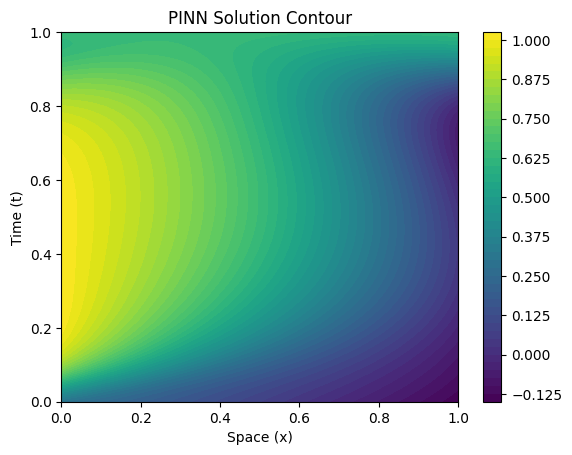

In [ ]:
plt.contourf(X_test, T_test, U_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('PINN Solution Contour')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_test, T_test, U_pred, cmap='viridis', edgecolor='none')
fig.colorbar(surf)
ax.set_xlabel('Space (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Solution (u)')
ax.set_title('PINN Solution Surface')
ax.view_init(elev=30, azim=-45)
plt.show()

NameError: name 'plt' is not defined